In [12]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Fungsi untuk membaca dan memproses dataset
def load_dataset(folder):
    images = []
    labels = []
    label_mapping = {
        "Cotton Wool": 0,
        "Enteric Septicemia of Catfish (ESC)": 1,
        "Fin Rot": 2,
        "Lymphocystis Disease Virus (LCDV)": 3,
        "Viral hemorrhagic septicemia (VHS)": 4,
        "White Spot": 5
    }

    for label in label_mapping.keys():
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = Image.open(img_path).convert("RGB")
            img = img.resize((224, 224))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label_mapping[label])

    return np.array(images), np.array(labels)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd '/content/drive/MyDrive/Fish-Disease'

/content/drive/MyDrive/Fish-Disease


In [16]:
# Load dataset
train_images, train_labels = load_dataset("train")
valid_images, valid_labels = load_dataset("valid")
test_images, test_labels = load_dataset("test")


In [17]:
# Normalisasi nilai piksel ke rentang [0, 1]
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

In [18]:
# Load pre-trained VGG-16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Learning Rate Schedule
def lr_schedule(epoch):
    initial_lr = 1e-4
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * np.exp(-0.1 * (epoch-5))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [20]:
# Model CNN
# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(6, activation='softmax'))
# Add L2 regularization to the dense layer
model.add(layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)))

#model = models.Sequential()
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(6, activation='softmax'))

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
# Image data augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [30]:
# Training model with callbacks
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=30,
                    validation_data=(valid_images, valid_labels),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
5/5 [==============================] - 5s 927ms/step - loss: 0.9214 - accuracy: 0.6806 - val_loss: 1.3804 - val_accuracy: 0.4643 - lr: 1.0000e-04
Epoch 2/30
5/5 [==============================] - 4s 685ms/step - loss: 0.8818 - accuracy: 0.7222 - val_loss: 1.3849 - val_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 3/30
5/5 [==============================] - 4s 697ms/step - loss: 0.8951 - accuracy: 0.6910 - val_loss: 1.3986 - val_accuracy: 0.4643 - lr: 1.0000e-04
Epoch 4/30
5/5 [==============================] - 5s 1s/step - loss: 0.8775 - accuracy: 0.7049 - val_loss: 1.4134 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/30
5/5 [==============================] - 4s 732ms/step - loss: 0.8607 - accuracy: 0.7014 - val_loss: 1.3701 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/30
5/5 [==============================] - 4s 678ms/step - loss: 0.8557 - accuracy: 0.7188 - val_loss: 1.4033 - val_accuracy: 0.5357 - lr: 1.0000e-04
Epoch 7/30
5/5 [==============================] - 4s 683ms/st

In [31]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Loss accuracy: {test_loss}')
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 157ms/step - loss: 1.1832 - accuracy: 0.6667
Loss accuracy: 1.1831718683242798
Test accuracy: 0.6666666865348816


In [32]:
# Prediksi menggunakan model
predictions = model.predict(test_images)

1/1 [==============================] - 0s 31ms/step


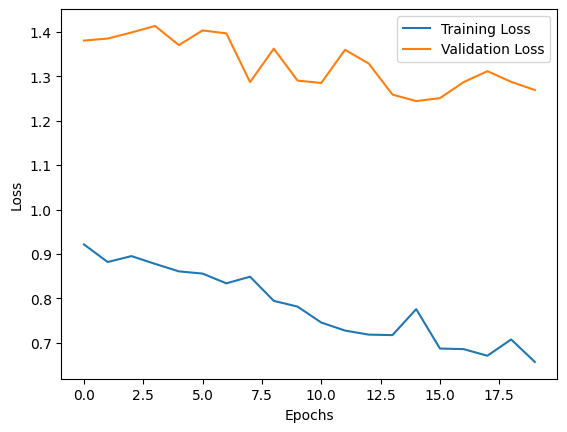

In [33]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

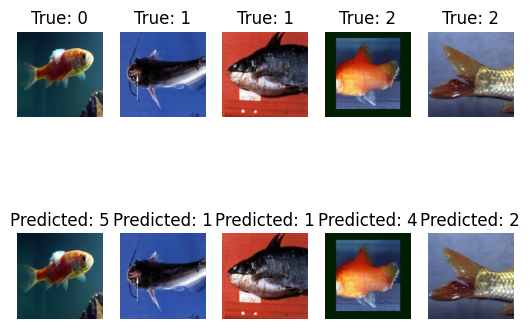

In [34]:
import matplotlib.pyplot as plt

# Pilih beberapa gambar dari dataset uji
num_samples = 5
selected_images = test_images[:num_samples]
selected_labels = test_labels[:num_samples]
selected_predictions = predictions[:num_samples]

# Visualisasikan hasil
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {selected_labels[i]}")
    plt.axis('off')

    plt.subplot(2, num_samples, i + 1 + num_samples)
    predicted_label = np.argmax(selected_predictions[i])
    plt.imshow(selected_images[i])
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

plt.show()

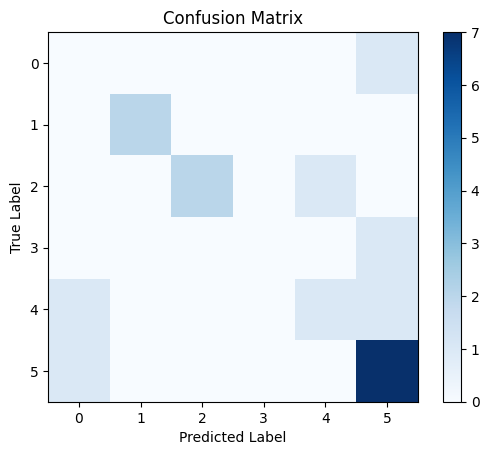

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         1
           4       0.50      0.33      0.40         3
           5       0.70      0.88      0.78         8

    accuracy                           0.67        18
   macro avg       0.53      0.48      0.50        18
weighted avg       0.67      0.67      0.66        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Confusion Matrix
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)

# Plot Confusion Matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))